# Bike sharing users perdiction

## Bike sharing linear Regressoin (Part A)

### Task instructions

Our goal is to predict the number of casual users using the other variables.

### Data description

There are nine features and one target variable.

* temp - normalized temperatures, i.e., range between zero and one
* temp_C - temperatures in degrees Celcius
* hum - humidity
* windspeed - normalized wind speed, i.e., ranges between zero and one
* atemp - apparent temperature which combines temperatures, wind speed and humidity
* atemp_C - apparent temperature in degrees Celcius
* yr - year: 0 for 2011 and 1 for 2012
* workingday - whether it's a working day
* holiday - whether it's a holiday
* casual - the target variable: number of casual users, i.e., users not registered

For this exercise, we ask you to detect and remove features that make the 
X
 matrix, with the column of ones, rank deficient. Also, you might want to remove nearly collinear features if you obtain better results without them.

In [1]:
import pandas as pd
import os

# Load data sets
train_df = pd.read_csv('bike-train2.csv')
test_df = pd.read_csv('bike-test2.csv')

In [2]:
# training shape
train_df.shape

(365, 10)

In [3]:
# test shape
test_df.shape

(366, 10)

In [4]:
train_df.head()

,temp,temp_C,hum,windspeed,atemp,atemp_C,yr,workingday,holiday,casual
0,0.368,9.296,0.569,0.148,0.379,9.014,1,1,0,1603
1,0.700,24.900,0.761,0.084,0.660,27.560,0,1,0,768
2,0.282,5.254,0.538,0.187,0.282,2.612,0,0,0,424
3,0.335,7.745,0.450,0.308,0.320,5.120,0,1,0,231
4,0.398,10.706,0.466,0.290,0.388,9.608,1,1,0,663


In [5]:
import numpy as np

In [7]:
feature = ['temp','hum','windspeed','yr','workingday','holiday']

In [8]:
X = train_df[feature].values
X1 = np.c_[np.ones(X.shape[0]),X]
y = train_df.casual.values

In [9]:
# Compute rank and condition number
M = X1.shape[1] # Number of columns
rank = np.linalg.matrix_rank(X1)
cond = np.linalg.cond(X1)
print('Columns {} rank {} collinear {}'.format(M, rank, M-rank))
print('Condition number:', cond)

Columns 7 rank 7 collinear 0
Condition number: 22.000828462946895


In [10]:
# Extract numpy arrays X/y for both sets
X_tr = train_df[feature].values
y_tr = train_df.casual.values

X_te = test_df[feature].values
y_te = test_df.casual.values

In [11]:
# we will test models with MAE
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [12]:
# (A) Linear regression
from sklearn.linear_model import LinearRegression

# Create a linear regression object
lr = LinearRegression()

# Fit the model
lr.fit(X_tr,y_tr)

# Print the coefficients
print('Coefficients:', lr.coef_)

print('Intercept:', lr.intercept_)

Coefficients: [ 2029.93927132  -518.58054201 -1235.9864496    254.1392439
  -842.07556261  -216.82954913]
Intercept: 870.3461082714265


In [13]:
# predict on test set
y_pred_lr = lr.predict(X_te)
mae_lr = MAE(y_te, y_pred_lr)

In [14]:
# (B) Huber loss
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(epsilon=1.35)

huber.fit(X_tr,y_tr)

print(huber.coef_, huber.intercept_)

y_pred_huber = huber.predict(X_te)
mae_huber = MAE(y_te, y_pred_huber)

[1904.54481063 -590.68806002 -965.607323    189.81251498 -802.27031864
 -351.32176627] 913.5970147028636


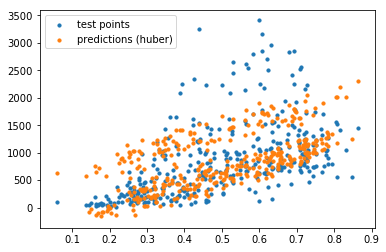

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot models
temp_te = X_te[:, 0] # 0: temperatures column
plt.scatter(temp_te, y_te, s=10, label='test points')
plt.scatter(temp_te, y_pred_huber, s=10, label='predictions (huber)')
plt.legend()
plt.show()

# shows with Huber that there seem to be two sources (we know that there is workingday vs non workingday source)

In [16]:
# (C) Baseline with linear regression deg=1
x_tr = train_df.temp.values
x_te = test_df.temp.values

coef = np.polyfit(x_tr,y_tr, deg=1)
y_pred_poly = np.polyval(coef, x_te)
mae_lr_poly = MAE(y_te, y_pred_poly)

In [17]:
# baseline with mean as well
mae_baseline = MAE(y_te, np.median(y_tr))

### Create model with two sources

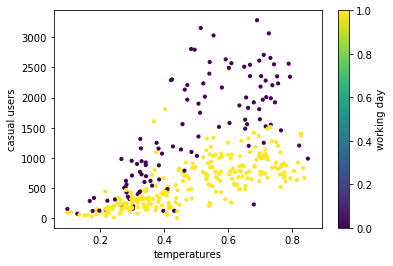

In [18]:
# We can identify two sources
temp_tr = X_tr[:, 0] # 0: temp column
wd_tr = X_tr[:, 4] # 4: workingday column

plt.scatter(temp_tr, y_tr, c=wd_tr, s=10)
plt.colorbar(label='working day')
plt.xlabel('temperatures')
plt.ylabel('casual users')
plt.show()

In [19]:
# Separate data points
# * wd: working day
# * nwd: non-working day
columns = [0, 1, 2, 3, 5] # Also, remove column 4: workingday

# Train set
wd_idx_tr = (X_tr[:, 4] == 1) # Entries with workingday == 1

X_tr_wd = X_tr[wd_idx_tr][:, columns]
y_tr_wd = y_tr[wd_idx_tr]

X_tr_nwd = X_tr[~wd_idx_tr][:, columns]
y_tr_nwd = y_tr[~wd_idx_tr]

# Test set
wd_idx_te = (X_te[:, 4] == 1) # Entries with workingday == 1

X_te_wd = X_te[wd_idx_te][:, columns]
y_te_wd = y_te[wd_idx_te]

X_te_nwd = X_te[~wd_idx_te][:, columns]
y_te_nwd = y_te[~wd_idx_te]

In [20]:
# Linear regression
lr_wd = LinearRegression() # Model for working days
lr_nwd = LinearRegression() # Model for non-working days

lr_wd.fit(X_tr_wd, y_tr_wd) # Fit models to train data
lr_nwd.fit(X_tr_nwd, y_tr_nwd)

LinearRegression()

In [21]:
y_pred_lr_wd = np.maximum(lr_wd.predict(X_te_wd), 50) # set minimum of 50 users to not be negative
y_pred_lr_nwd = np.maximum(lr_nwd.predict(X_te_nwd), 50)

In [22]:
# Ressamble data

# target value
y_te_wdnwd = np.concatenate((y_te_wd,y_te_nwd))

# pred value
y_pred_lr_wdnwd = np.concatenate((y_pred_lr_wd,y_pred_lr_nwd))

mae_two_models = MAE(y_te_wdnwd, y_pred_lr_wdnwd)

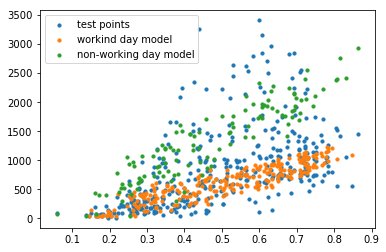

In [23]:
# Plot temperatures for working days and non-working days
temp_te_wdnwd = np.concatenate((X_te_wd[:, 0], X_te_nwd[:, 0]))
plt.scatter(temp_te_wdnwd, y_te_wdnwd, s=10, label='test points')

# Predictions for working days
plt.scatter(X_te_wd[:, 0], y_pred_lr_wd, s=10, label='workind day model')

# Predictions for non-working days
plt.scatter(X_te_nwd[:, 0], y_pred_lr_nwd, s=10, label='non-working day model')

plt.legend()
plt.show()

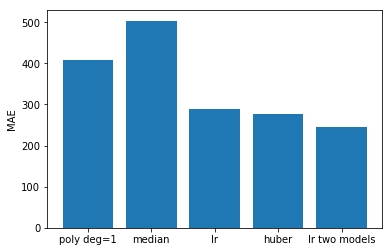

In [24]:
# Final comparison
mae_values = [mae_lr_poly, mae_baseline, mae_lr, mae_huber, mae_two_models]
titles = ['poly deg=1','median', 'lr', 'huber', 'lr two models']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()

In [25]:
# R2 coefficients
r2_lr = lr.score(X_te, y_te)
r2_huber = huber.score(X_te, y_te)

print('R^2 linear regression:', r2_lr)
print('R^2 huber loss:', r2_huber)

# R2 coefficient when separating sources
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

rss_lr_wdnwd = RSS(y_te_wdnwd, y_pred_lr_wdnwd)
rss_baseline = RSS(y_te, y_te.mean())
r2_lr_wdnwd = 1 - rss_lr_wdnwd/rss_baseline

print('R^2 when separating sources:', r2_lr_wdnwd)

R^2 linear regression: 0.6680357017933192
R^2 huber loss: 0.6660473610357539
R^2 when separating sources: 0.7250821656146723


#### Comments
* LinearRegression with two models is over-performing all other models which is also confirm in the R2 score

## Bike sharing polynomial features (Part B)

The goal of this exercise is to experiment with feature engineering, data splitting, and one-hot encoding.

### Data description

You are going to work with the bike sharing data set from the previous exercise with three additional features.

* $weekday$ - day of the week
* $season$ - season of the year
* $weathersit$ - type of weather

These are all categorical features, which you will have to be encoded using **one-hot encoding** before applying linear regressions. Read the "attribute information" section from the data set web page to learn about these three features and their possible values.

In [26]:
import pandas as pd
import numpy as np

# load data
data_df = pd.read_csv('bike-sharingbis.csv')
print('Shape:',data_df.shape)

# First 5 rows
data_df.head()

Shape: (731, 10)


,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.160,2011,no,no,6,spring,cloudy,331
1,0.363,0.696,0.249,2011,no,no,0,spring,cloudy,131
2,0.196,0.437,0.248,2011,yes,no,1,spring,clear,120
3,0.200,0.590,0.160,2011,yes,no,2,spring,clear,108
4,0.227,0.437,0.187,2011,yes,no,3,spring,clear,82


In [27]:
# Check values in 'weathersit' column
data_df['weathersit'].unique()

array(['cloudy', 'clear', 'rainy'], dtype=object)

In [28]:
# Get dummy variable with One-hot encoding
pd.get_dummies(data_df, columns=['yr','workingday','holiday','weekday','season','weathersit'],drop_first=True).head()

,temp,hum,windspeed,casual,yr_2012,workingday_yes,holiday_yes,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,season_spring,season_summer,season_winter,weathersit_cloudy,weathersit_rainy
0,0.344,0.806,0.160,331,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,0.363,0.696,0.249,131,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.196,0.437,0.248,120,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,0.200,0.590,0.160,108,0,1,0,0,1,0,0,0,0,1,0,0,0,0
4,0.227,0.437,0.187,82,0,1,0,0,0,1,0,0,0,1,0,0,0,0


In [29]:
df = pd.get_dummies(data_df, columns=['yr','workingday','holiday','weekday','season','weathersit'],drop_first=True)

In [30]:
n = len(df['temp'])
indexes = np.arange(n)

In [31]:
np.random.seed(0)
np.random.shuffle(indexes)

In [32]:
split_idx = int(n*0.7)
train = df[:split_idx]
test = df[split_idx:]
print('Share train:',train.shape)
print('Share test:',test.shape)

Share train: (511, 18)
Share test: (220, 18)


In [33]:
X_tr, X_te = train.drop('casual', axis=1).values, test.drop('casual', axis=1).values
y_tr, y_te = train.casual.values, test.casual.values

In [34]:
# Can also be done directly with 'train_test_split'
#from sklearn.model_selection import train_test_split

# Split data
#x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=0)

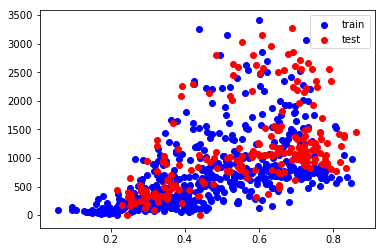

In [35]:
# Vizualize distribution of train and test values (can only be done with one of the input variables)
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X_tr[:,0], y_tr, c='blue', label='train')
plt.scatter(X_te[:,0], y_te, c='red', label='test')
plt.legend()
plt.show()

In [36]:
# (A) LinearRegression model
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_tr, y_tr)
linreg.score(X_tr, y_tr)

0.7038990476595522

In [37]:
from sklearn.metrics import mean_squared_error as mse

def MAE(y, y_pred):
    return np.median(np.abs(y - np.maximum((y_pred),50))) # set lower limit at 50

y_pred_tr = linreg.predict(X_tr)
print('MSE train:',mse(y_tr, y_pred_tr))
print('MAE train:',MAE(y_tr, y_pred_tr))
y_pred_te = linreg.predict(X_te)
print('MSE test:',mse(y_te, y_pred_te))
print('MAE test:',MAE(y_te, y_pred_te))

# Add baseline as well
print('MAE train:',MAE(y_tr,np.median(y_tr)))
print('MAE test:',MAE(y_te,np.median(y_tr)))

MSE train: 115828.11662222238
MAE train: 157.43742243196868
MSE test: 174382.16120481506
MAE test: 191.71925651648814
MAE train: 371.0
MAE test: 420.0


In [38]:
# (B) Ridge model to cover for ill-conditioning
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1e-4)
ridge.fit(X_tr, y_tr)
y_pred = ridge.predict(X_te)

print('MSE test:',mse(y_te,y_pred))

MSE test: 174382.2140738319


### Add polynomial features

In [39]:
# Function to add features
def create_features(df):
    temp = df.temp.values
    others = df.drop(['temp', 'casual'], axis=1).values
    return np.c_[temp, temp**2, temp**3, others]

In [40]:
from sklearn.linear_model import LinearRegression, Ridge

# Function to fit the model
def fit_model(X_train, y_train, X_test):
    # Create the model
    # Note: Using ridge with a small alpha to avoid ill-conditioning issues
    model = Ridge(alpha=1e-4) # or LinearRegression()
    
    # Fit it to train data
    model.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = np.maximum(
        model.predict(X_test),
        50 # set a lower limit
    )
    
    return y_pred

# Create new input matrices
X_tr2 = create_features(train)
X_te2 = create_features(test)

# Fit a linear regression
y_pred_lr = fit_model(X_tr2, y_tr, X_te2)
mae_lr2 = MAE(y_te, y_pred_lr)
print('MAE lr with new features: {:.3f}'.format(mae_lr2))

MAE lr with new features: 164.258


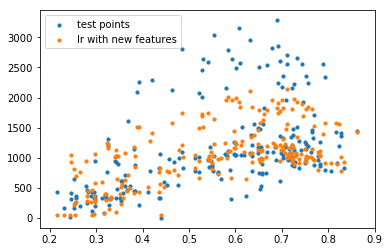

In [41]:
# Plot predictions
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(test.temp, test.casual, s=10, label='test points')
plt.scatter(test.temp, y_pred_lr, s=10, label='lr with new features')
plt.legend()
plt.show()

### Seperate sources

In the last exercise, we saw that we can identify two sources in the data.

1. Data points collected during working days
2. Data points collected during non-working days

The goal of this exercise is to create a model for each source using your extended set of features, e.g., the original features plus the temp^2, temp^3 polynomial features.


In [42]:
# Split data into working days (wd) and non-working days (nwd)
train_df_wd = train[train.workingday_yes == 1]
train_df_nwd = train[train.workingday_yes == 0]

test_df_wd = test[test.workingday_yes == 1]
test_df_nwd = test[test.workingday_yes == 0]

In [43]:
# Fit two linear regressions
y_pred_wd = fit_model(
    create_features(train_df_wd),
    train_df_wd.casual,
    create_features(test_df_wd)
)
y_pred_nwd = fit_model(
    create_features(train_df_nwd),
    train_df_nwd.casual,
    create_features(test_df_nwd)
)

# Reassemble predictions
y_pred_wdnwd = np.concatenate([y_pred_wd, y_pred_nwd])
y_te_wdnwd = np.concatenate([
    test_df_wd.casual,
    test_df_nwd.casual
])

# Compute MAE
mae_wdnwd = MAE(y_te_wdnwd, y_pred_wdnwd)
print('MAE two sources: {:.3f}'.format(mae_wdnwd))

MAE two sources: 167.373


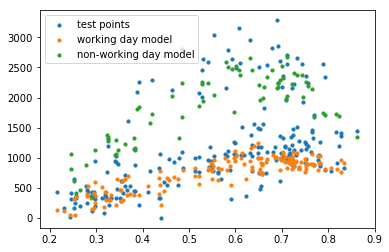

In [44]:
# Plot predictions
temp_te_wdnwd = np.concatenate([test_df_wd.temp, test_df_nwd.temp])
plt.scatter(temp_te_wdnwd, y_te_wdnwd, s=10, label='test points')
plt.scatter(test_df_wd.temp, y_pred_wd, s=10, label='working day model')
plt.scatter(test_df_nwd.temp, y_pred_nwd, s=10, label='non-working day model')

plt.legend()
plt.show()

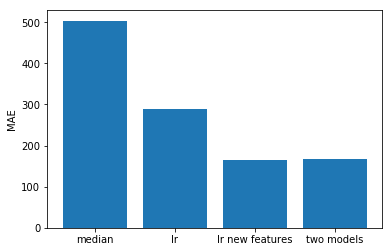

In [45]:
# Final comparison
mae_values = [mae_baseline, mae_lr, mae_lr2, mae_wdnwd]
titles = ['median', 'lr', 'lr new features', 'two models']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()